In [1]:
import ee
import numpy as np
import pandas as pd

from earthshot import mon_stats
from earthshot import water_viz as vis
from earthshot import normalize as norm
from earthshot import water_common as common
from statistics import mean

import geemap.eefolium as geemap
import folium
from folium import plugins

import matplotlib.pyplot as plt
%matplotlib inline


Loading BokehJS ...

In [2]:
ee.Initialize()

In [3]:
#Import Global MAR Inventory, global groundwater info
MAR_swales = ee.FeatureCollection('users/amgadellaboudy/Global_MAR_Inventory')
MAR_swales_remapped = MAR_swales.remap(['In-Channel Modification', 
                  'Induced Bank Filtration', 
                  'Rainwater and Run-off Harvesting', 
                  'Spreading Methods', 
                  'Well, Shaft and Borehole Recharge'],
                [float(0), float(1), float(2) , float(3) ,float(4)],
                'main_mar_t')

#import groundwater and aquifer information in
groundwater_1 = ee.FeatureCollection('users/amgadellaboudy/groundwater_info')
groundwater_2 = ee.FeatureCollection('users/amgadellaboudy/groundwater_info_2')
aquifer = ee.FeatureCollection('users/amgadellaboudy/aquifer_characteristics')

def missing_values(image):
    mask = image.gte(0)
    image_masked = image.updateMask(mask)
    return image_masked

water_area_img= groundwater_1.reduceToImage(properties = ['waterarea'], reducer = ee.Reducer.first())
total_renew_water_img= groundwater_1.reduceToImage(properties = ['totrenewab'], reducer = ee.Reducer.first())
arid_land_img= groundwater_1.reduceToImage(properties = ['extofaridl'], reducer = ee.Reducer.first())
humid_land_img= groundwater_1.reduceToImage(properties = ['extofhumid'], reducer = ee.Reducer.first())
gw_recharge_img= groundwater_2.reduceToImage(properties = ['annualgwre'], reducer = ee.Reducer.first())
aquifer_without_img = aquifer.reduceToImage(properties = ['extofareaswithoutsignificantaq'], reducer = ee.Reducer.first())
volcanic_aquifer_img = aquifer.reduceToImage(properties = ['extofconsolidatedvolcanicaquif'], reducer = ee.Reducer.first())
fissured_aquifer_img = aquifer.reduceToImage(properties = ['extoffissuredaquifers'], reducer = ee.Reducer.first())
intergranular_aquifer_img = aquifer.reduceToImage(properties = ['extofintergranularaquifers'], reducer = ee.Reducer.first())
metamorphic_aquifer_img = aquifer.reduceToImage(properties = ['extofintrusiveormetamorphicroc'], reducer = ee.Reducer.first())
limestone_aquifer_img = aquifer.reduceToImage(properties = ['extoflimestonedolomiteaquifers'], reducer = ee.Reducer.first())
sandgravel_aquifer_img = aquifer.reduceToImage(properties = ['extofsandgravelaquifers'], reducer = ee.Reducer.first())
sandstone_aquifer_img = aquifer.reduceToImage(properties = ['extofsandstoneaquifers'], reducer = ee.Reducer.first())
unconsolidated_volcnanic_aquifer_img = aquifer.reduceToImage(properties = ['extofunconsolidatedvolcanicaqu'], reducer = ee.Reducer.first())
kastifiedzones_img = aquifer.reduceToImage(properties = ['occofkarstifiedzonesincarbonat'], reducer = ee.Reducer.first())



281


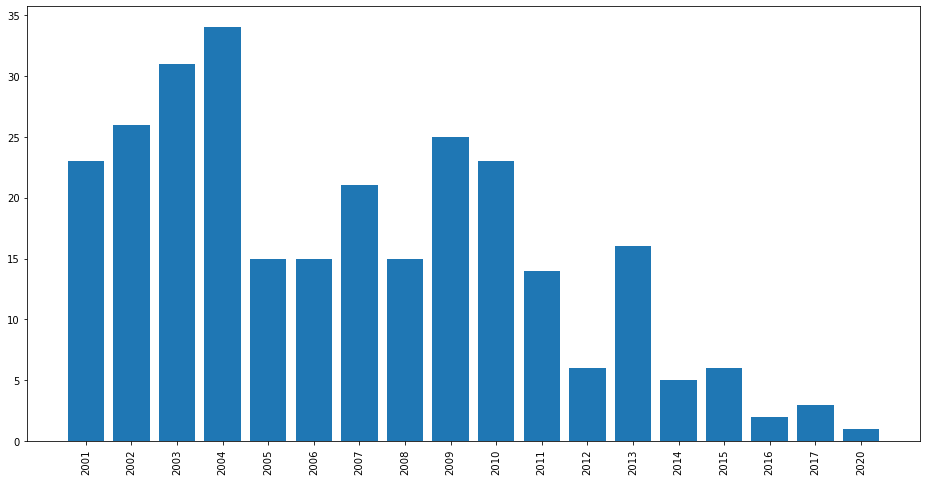

In [4]:
MAR_swales_filtered = MAR_swales_remapped.filter('year_opera > 2000')
MAR_dict = MAR_swales_filtered.aggregate_histogram('year_opera').getInfo()

print(MAR_swales_filtered.size().getInfo())

fig, ax = plt.subplots(figsize = (16,8))
plt.xticks(rotation = 90)
plt.bar(MAR_dict.keys(), MAR_dict.values())
plt.show()

In [4]:
#Import variables in (Slope, Porosity, Runoff, Soil Types, Annual Precipitation, water accumulation)
slope_img = ee.Image('users/jamesmcc/merit_slope/merit_terrain_slope')
#Scale = 90 m

smap_usda_clim = ee.ImageCollection('users/jamesmcc/smap_usda_climatology')
avail_porosity = (smap_usda_clim
                  .filter(ee.Filter.eq('band', 'avail_porosity_mm')))
avail_porosity_img = avail_porosity.sum()

runoff_clim = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY").select('surface_runoff')
runoff_clim_m = mon_stats.bands_avgs(['surface_runoff'], runoff_clim)
runoff_img = ee.ImageCollection(runoff_clim_m['avgs'].get('surface_runoff')).sum().multiply(720)

precip_clim = ee.Image("OpenLandMap/CLM/CLM_PRECIPITATION_SM2RAIN_M/v01")
precip_img = precip_clim.reduce('sum')
#https://developers.google.com/earth-engine/datasets/catalog/OpenLandMap_CLM_CLM_PRECIPITATION_SM2RAIN_M_v01#bands
#Scale = 1 km

soil_types = ee.Image("OpenLandMap/SOL/SOL_TEXTURE-CLASS_USDA-TT_M/v02")

top_soils = soil_types.expression('soil_0 + soil_10 + soil_30',
                             {'soil_0': soil_types.select('b0'),
                             'soil_10': soil_types.select('b10'),
                             'soil_30': soil_types.select('b30')})

bottom_soils = soil_types.expression('soil_60 + soil_100 + soil_200',
                                 {'soil_60': soil_types.select('b60'),
                                  'soil_100': soil_types.select('b100'),
                                  'soil_200': soil_types.select('b200')})

#Scale = 250 m

#vegetation = ee.ImageCollection('MODIS/006/MOD13Q1')
#vegetation_img = vegetation.reduce('mean').select('EVI_mean')
#Measure of vegetation, https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD13Q1#bands


water_img = ee.Image('WWF/HydroSHEDS/15ACC').select('b1')
#Measure of water accumulation: https://developers.google.com/earth-engine/datasets/catalog/WWF_HydroSHEDS_15ACC
#Scale = 462 m

organic_matter = ee.Image("OpenLandMap/SOL/SOL_ORGANIC-CARBON_USDA-6A1C_M/v02").reduce(ee.Reducer.sum())
#measure of total organic matter in soil, from 0 to 200 m soil depth
#https://developers.google.com/earth-engine/datasets/catalog/OpenLandMap_SOL_SOL_ORGANIC-CARBON_USDA-6A1C_M_v02

In [5]:
#Collect images into one image, convert into feature collection that includes location and type of MAR interventions

img_1 = slope_img.addBands(avail_porosity_img)
img_2 = img_1.addBands(runoff_img)
img_3 = img_2.addBands(precip_img)
img_4 = img_3.addBands(top_soils)
img_5 = img_4.addBands(bottom_soils)
img_6 = img_5.addBands(water_area_img)
img_7 = img_6.addBands(total_renew_water_img)
img_8 = img_7.addBands(arid_land_img)
img_9 = img_8.addBands(humid_land_img)
img_10 = img_9.addBands(gw_recharge_img)
img_11 = img_10.addBands(aquifer_without_img)
img_12 = img_11.addBands(volcanic_aquifer_img)
img_13 = img_12.addBands(fissured_aquifer_img)
img_14 = img_13.addBands(intergranular_aquifer_img)
img_15 = img_14.addBands(metamorphic_aquifer_img)
img_16 = img_15.addBands(limestone_aquifer_img)
img_17 = img_16.addBands(sandgravel_aquifer_img)
img_18 = img_17.addBands(sandstone_aquifer_img)
img_19 = img_18.addBands(unconsolidated_volcnanic_aquifer_img)
img_20 = img_19.addBands(organic_matter)
#img_21 = img_20.addBands(kastifiedzones_img)
training_img = img_20.addBands(water_img)

mask = training_img.gte(0)
training_img_masked = training_img.updateMask(mask)

In [6]:
target = 'main_mar_t'
bands = ['slope', 'avail_porosity_mm', 'surface_runoff', 'sum', 'b0', 'b60','b1', 'first', 'first_1', 'first_2', 'first_3', 'first_4',
        'first_5','first_6','first_7','first_8','first_9','first_10','first_11','first_12','first_13', 'sum_1']

training = training_img_masked.sampleRegions(collection= MAR_swales_remapped, properties = [target], scale = 90, geometries = True)

In [7]:
print(training.size().getInfo())

387


In [8]:
#Test/ validation split, fit classifier for training data

split = 0.7
training = training.randomColumn()

training_split = training.filter(ee.Filter.lt('random', split))
validation_split = training.filter(ee.Filter.gte('random', split))

classifier = ee.Classifier.smileGradientTreeBoost(2000).train(features= training_split, classProperty= target, inputProperties = bands)

In [9]:
#Create predicted MAR intervention image and validation data

classified = training_split.classify(classifier)
validated = validation_split.classify(classifier)

In [10]:
#Training accuracy

trainAccuracy = classified.errorMatrix('main_mar_t', 'classification')
print('Resubstitution error matrix: ', trainAccuracy.getInfo())
print('Training overall accuracy: ', trainAccuracy.accuracy().getInfo())

Resubstitution error matrix:  [[31, 0, 0, 0, 0], [0, 32, 0, 0, 0], [0, 0, 3, 0, 0], [0, 0, 0, 91, 0], [0, 0, 0, 0, 134]]
Training overall accuracy:  1


In [11]:
#Validation accuracy

validationAccuracy = validated.errorMatrix('main_mar_t', 'classification')
print('Validation error matrix: ', validationAccuracy.getInfo())
print('Validation overall accuracy: ', validationAccuracy.accuracy().getInfo())

Validation error matrix:  [[12, 0, 0, 1, 2], [0, 8, 0, 0, 3], [0, 0, 0, 0, 0], [0, 1, 0, 9, 10], [0, 2, 0, 10, 38]]
Validation overall accuracy:  0.6979166666666666


In [12]:
classified_img = training_img.classify(classifier)

In [13]:
bbox_global = ee.Geometry.BBox(-180,-90,180,90)
bbox_conus = common.bboxes()['conus']

In [14]:
#Create map of predicted successful MAR projects based on variables



the_map = geemap.Map()

labels = ['In-Channel Modification', 
                  'Induced Bank Filtration', 
                  'Rainwater and Run-off Harvesting', 
                  'Spreading Methods', 
                  'Well, Shaft and Borehole Recharge']

colors = ['#00ff00', '#ffff00', '#ffa500', '#ff0000', '#0000FF']


vis_params = {
    'min': 0, 'max': 4, 'dimensions': 512,
    'palette': ['#00ff00', '#ffff00', '#ffa500', '#ff0000', '#0000FF']}

runoff_mask = runoff_img.gte(0.01) 
slope_mask = slope_img.lte(10)

classified_img_masked = classified_img.updateMask(runoff_mask).updateMask(slope_mask)

the_map.addLayer(classified_img_masked, vis_params, name = 'MAR techniques')
the_map.add_legend(title='Legend', labels=labels, colors=colors)
vis.folium_display(the_map)

In [15]:
#Export to GEE

#xx = ee.batch.Export.image.toAsset(
   #     classified_img,
    #    description = 'US Export Image',
    #    region = bbox_conus,
    #    assetId = 'users/amgadellaboudy/US_MAR_Classification',
     #   scale = 90,
      #  maxPixels = 100000000000).start()